# **Analisis de Sentimientos - Imdb-movie-reviews (CNN-LSTM)**
***Modelo LSTM para clasificar el sentimiento de las críticas de películas.***



# **REF:**

- https://www.kaggle.com/code/taha07/sentiment-analysis-imdb-movie-reviews/notebook
- https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
- Publications Using the Dataset: Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011). http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf .

# **ALCANCES**

- DATASET:
>- Acerca del conjunto de datos

Conjunto de datos de IMDB con 50.000 críticas de películas para el procesamiento del lenguaje natural o el análisis de texto.
Se trata de un conjunto de datos para la clasificación binaria de sentimientos que contiene muchos más datos que los anteriores conjuntos de datos de referencia. Proporcionamos un conjunto de 25.000 críticas de películas altamente polares para el entrenamiento y 25.000 para las pruebas. Así, se puede predecir el número de críticas positivas y negativas utilizando algoritmos de clasificación o de aprendizaje profundo.


# Word Embedding
Word embedding es el nombre de un conjunto de lenguajes de modelado y técnicas de aprendizaje en procesamiento del lenguaje natural (NLP) en donde las palabras o frases del vocabulario son vinculadas a vectores en el espacio real. Conceptualmente implica el encaje matemático de un espacio con una dimensión por palabra a un espacio vectorial continuo con menos dimensiones.

El Word y Phrase embeddings, utilizados de forma subyacente como forma de representación, han demostrado aumentar el rendimiento de tareas en el procesamiento del lenguaje natural, así como en el análisis sintáctico y análisis de sentimientos.

Esta técnica supone una mejora sustancial frente a los esquemas tradicionales de encoding de palabras, que eran usados para representar cada palabra como un vector con respecto a todo un vocabulario. Cuando el vocabulario es vasto, una única palabra por lo general se identificaba con un vector que contenía un gran número de elementos nulos. Sin embargo, en un embedding, las palabras se representan por vectores donde cada vector representa la proyección de una palabra en un espacio vectorial.

La posición de una palabra en ese espacio vectorial está basada no sólo en las características de la palabra, sino también enlas palabras que la rodean. Hay dos ejemplos muy populares de aprendizaje de Word Embedding:

Word2Vec y GloVe.

# La clasificación de secuencias

La clasificación de secuencias es un problema de modelado predictivo en el que se tiene una secuencia de entradas sobre el espacio o el tiempo y la tarea es predecir una categoría para la secuencia.

Lo que hace que abarcar este problema no sea inmediato es que las secuencias pueden variar en longitud, estar compuestas de un vocabulario muy grande de símbolos de entrada y pueden requerir que el modelo aprenda el contexto a largo plazo o las relaciones entre símbolos en la secuencia de entrada.


***Carga del dataset***

Comencemos importando las clases y funciones requeridas para este modelo e inicializando el generador de números aleatorios a un valor constante para asegurar que podamos reproducir fácilmente los resultados.

In [1]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/DataSet/IMDB Dataset/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


>Checking for null values:

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

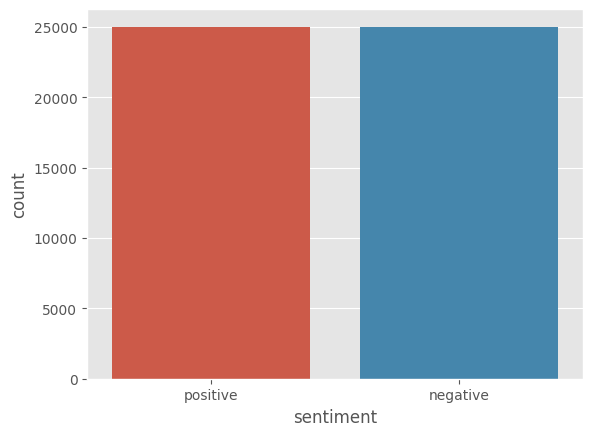

In [6]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [7]:
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

- So, there is no class imbalance both class has an equal number of data.

In [8]:
df["review"][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [9]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
!pip3 install nltk

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from nltk.corpus import stopwords

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        return sentence

In [14]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [15]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [16]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [17]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

> Creating Embedding Layer:

- Una capa de incrustación se utiliza normalmente para convertir palabras o tokens de un vocabulario en vectores densos de longitud fija, a menudo denominados incrustación de palabras o vectores de palabras.
- A cada palabra del vocabulario se le asigna una representación vectorial única en el espacio de incrustación.
- Estas incrustaciones de palabras se aprenden mediante el proceso de entrenamiento, en el que el modelo ajusta los valores de los vectores para optimizar la tarea en cuestión, como el análisis de sentimientos, la traducción automática o la generación de texto.



***NOTA:***

**TOKENIZACIÓN:**

- La tokenización, en el ámbito del Procesamiento del Lenguaje Natural (NLP) y el aprendizaje automático (ML), se refiere al proceso de convertir una secuencia de texto en partes más pequeñas, conocidas como tokens.
- Estos tokens pueden ser tan pequeños como caracteres o tan largos como palabras.

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [19]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [20]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

92394

In [21]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [22]:
embedding_dict = dict()
glove_file = open("/content/drive/MyDrive/DataSet/IMDB Dataset/glove.6B.100d.txt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

In [23]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [24]:
embeddings_dictionary.get('movie')

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

In [25]:
embeddings_dictionary['film']

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [26]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
embedding_matrix.shape

(92394, 100)

> Model Building:
>> Simple Neural Network:

In [28]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

In [29]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9399433 (35.86 MB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [30]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 6s 4ms/step - loss: 0.5552 - accuracy: 0.7135 - val_loss: 0.5099 - val_accuracy: 0.7527
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.8049 - val_loss: 0.4993 - val_accuracy: 0.7626
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3771 - accuracy: 0.8332 - val_loss: 0.5062 - val_accuracy: 0.7665
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3365 - accuracy: 0.8558 - val_loss: 0.5464 - val_accuracy: 0.7582
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.2965 - accuracy: 0.8762 - val_loss: 0.5486 - val_accuracy: 0.7541
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2613 - accuracy: 0.8934 - val_loss: 0.5945 - val_accuracy: 0.7571
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2250 - accuracy: 0.9113 - val_loss: 0.6598 - val_accuracy: 0.7500
Epoch 

In [31]:
result = snn.evaluate(x_test,y_test, verbose = 1)

313/313 [==============================] - 1s 2ms/step - loss: 0.8537 - accuracy: 0.7280


In [32]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.7279999852180481
Test Loss: 0.853721559047699


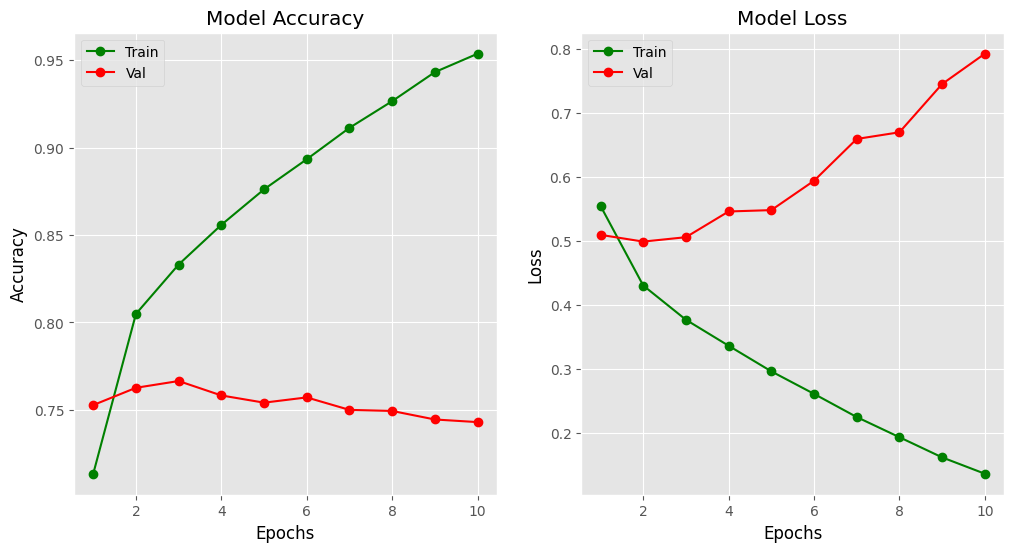

In [33]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> Convolutional Neural Network:

In [34]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [35]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 dropout (Dropout)           (None, 96, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 256)           164096    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

In [36]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 10s 10ms/step - loss: 0.4915 - accuracy: 0.7554 - val_loss: 0.3877 - val_accuracy: 0.8311
Epoch 2/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3779 - accuracy: 0.8325 - val_loss: 0.3616 - val_accuracy: 0.8404
Epoch 3/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3420 - accuracy: 0.8498 - val_loss: 0.3426 - val_accuracy: 0.8490
Epoch 4/10
250/250 [==============================] - 2s 9ms/step - loss: 0.3012 - accuracy: 0.8735 - val_loss: 0.3385 - val_accuracy: 0.8529
Epoch 5/10
250/250 [==============================] - 2s 9ms/step - loss: 0.2619 - accuracy: 0.8920 - val_loss: 0.3422 - val_accuracy: 0.8509
Epoch 6/10
250/250 [==============================] - 2s 9ms/step - loss: 0.2259 - accuracy: 0.9110 - val_loss: 0.3423 - val_accuracy: 0.8510
Epoch 7/10
250/250 [==============================] - 2s 9ms/step - loss: 0.1966 - accuracy: 0.9240 - val_loss: 0.3686 - val_accuracy: 0.8451
Epoc

In [37]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 [==============================] - 1s 4ms/step - loss: 0.4124 - accuracy: 0.8491
Test Accuracy: 0.8490999937057495
Test Loss: 0.41236019134521484


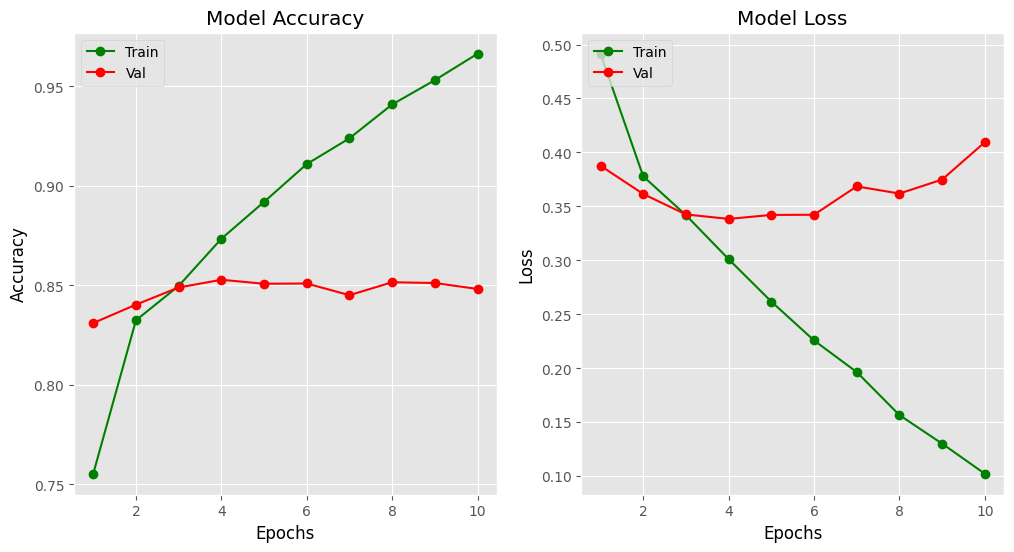

In [38]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

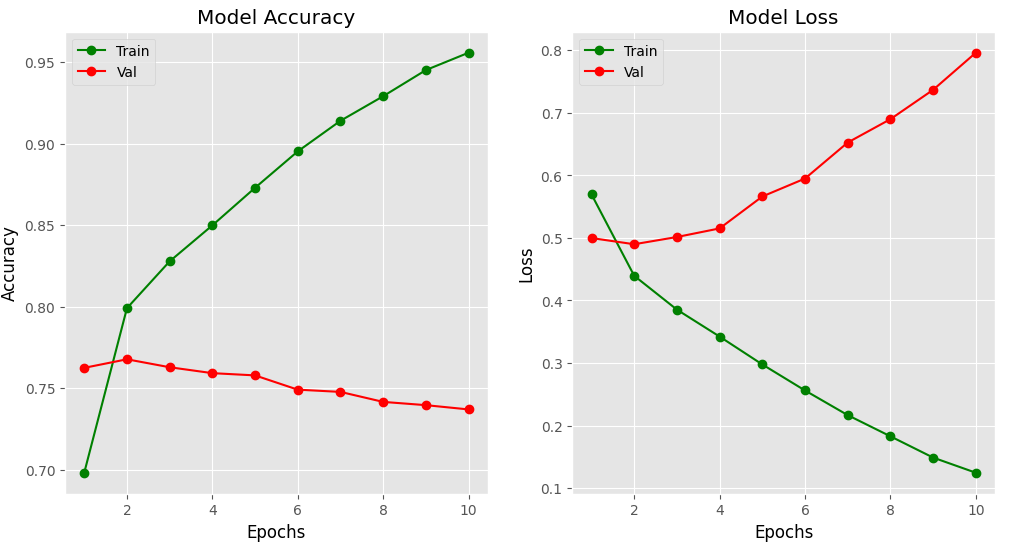

# LSTM

In [39]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True

# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))

# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [40]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [41]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10,
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 [==============================] - 6s 11ms/step - loss: 0.5148 - accuracy: 0.7440 - val_loss: 0.4149 - val_accuracy: 0.8144
Epoch 2/10
250/250 [==============================] - 2s 9ms/step - loss: 0.4134 - accuracy: 0.8161 - val_loss: 0.3741 - val_accuracy: 0.8389
Epoch 3/10
250/250 [==============================] - 2s 9ms/step - loss: 0.3743 - accuracy: 0.8380 - val_loss: 0.3508 - val_accuracy: 0.8415
Epoch 4/10
250/250 [==============================] - 2s 9ms/step - loss: 0.3439 - accuracy: 0.8543 - val_loss: 0.3492 - val_accuracy: 0.8534
Epoch 5/10
250/250 [==============================] - 2s 10ms/step - loss: 0.3221 - accuracy: 0.8647 - val_loss: 0.3429 - val_accuracy: 0.8572
Epoch 6/10
250/250 [==============================] - 2s 9ms/step - loss: 0.3049 - accuracy: 0.8734 - val_loss: 0.3223 - val_accuracy: 0.8661
Epoch 7/10
250/250 [==============================] - 2s 9ms/step - loss: 0.2901 - accuracy: 0.8815 - val_loss: 0.3028 - val_accuracy: 0.8726
Epoc

In [42]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 [==============================] - 1s 5ms/step - loss: 0.3305 - accuracy: 0.8692
Test Accuracy: 0.8691999912261963
Test Loss: 0.3305121958255768


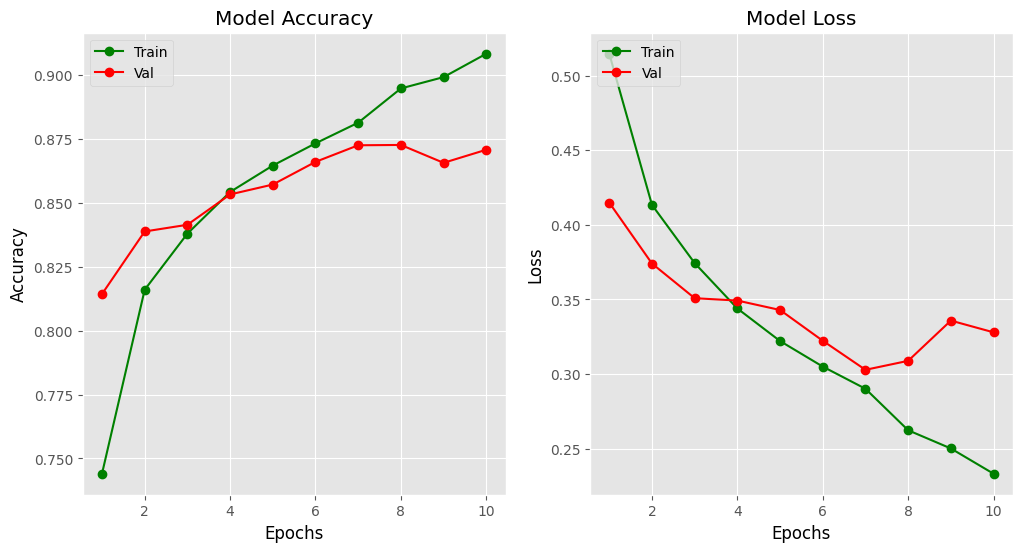

In [43]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

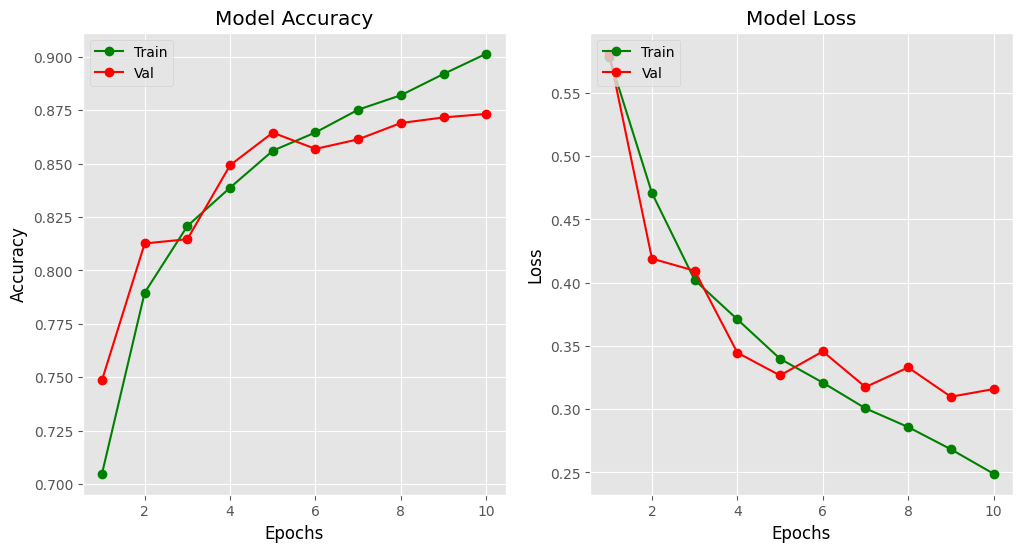

In [44]:
lstm.save("sentiment_classifier2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
